In [1]:
%run ../ipython/ipy_setup.py
%matplotlib inline
import pysam

In [2]:
basedir = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/'
bam_fp = pysam.Samfile(basedir + 'hg002_000000F.new.merged.bam', 'rb')

In [ ]:
# get methylation by column (slow)

motif_ipd_values = dict()

pbar = ProgressBar(33500000)
count =0
for i in bam_fp.pileup():
    pbar.animate()
    for read in i.pileups:
        qpos = read.query_position
        if (qpos < 4 )|(qpos > read.alignment.query_length - 4) :
            continue # cannot determine full motif
        motif = read.alignment.query_sequence[qpos-3:qpos+4]
        ipd_value = int(read.alignment.get_tag('ip').split(',', qpos+1)[qpos].strip('S'))
        if motif in motif_ipd_values:
            motif_ipd_values[motif].append(ipd_value)
        else:
            motif_ipd_values[motif] = [ipd_value]

In [3]:
# get methylation by read (hopefully faster)
basedir = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/'
bam_fp = pysam.Samfile(basedir + 'hg002_000000F.new.merged.bam', 'rb')
motif_ipd_values_read = dict()

pbar = ProgressBar(450000)
count=0
for read in bam_fp.fetch():
    pbar.animate()
    ipd_values = [int(i) for i in read.get_tag('ip').strip('S').split(',')]
    qlength = read.query_length
    sequence = read.query_sequence
    for basepos in range(6,qlength-6):
        motif = sequence[basepos-5:basepos+6]
        ipd_value = ipd_values[basepos+1] # the important IPD value is AFTER the base in question.
        if motif in motif_ipd_values_read:
            motif_ipd_values_read[motif].append(ipd_value)
        else:
            motif_ipd_values_read[motif] = [ipd_value]

[********         21%                  ]  92867 of 450000 complete Elapsed: 64.4 minutes	 Remaining: 247.7 minutes

KeyboardInterrupt: 

In [4]:
len(motif_ipd_values_read)

4194265

In [11]:
import pickle
with open('/hpc/users/neffr01/2work/methyl_motif_priors/hg002_92k-reads.pickle2', 'w') as fp:
    pickle.dump(motif_ipd_values_read, fp, 2)

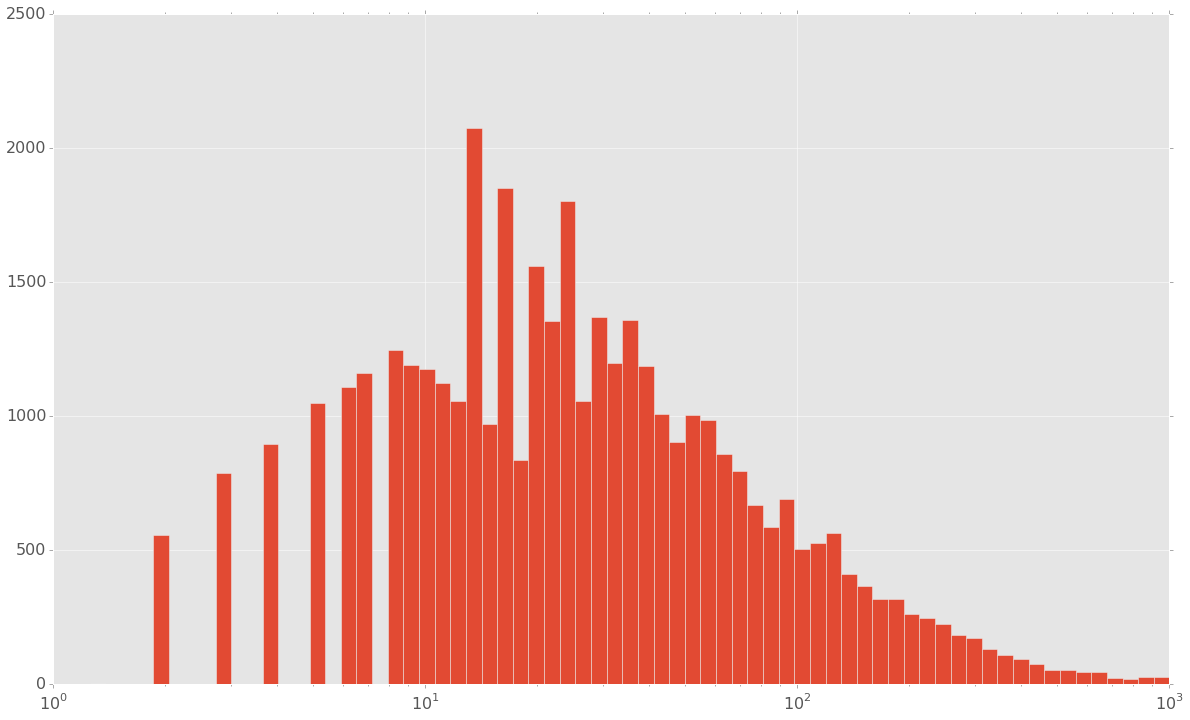

In [8]:
pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20, 12)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'
plt.hist(motif_ipd_values_read['TATATATATAT'], bins=np.logspace(0.1,3,70))
plt.xscale('log')
plt.show()

In [ ]:
import cProfile
import re
cProfile.run('test_it(bam_fp)', sort=1)